In [1]:
# Importation des bibliothèques nécessaires
import os
import glob
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from tensorflow.keras.layers import Dense, Flatten, Reshape, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import gc  # Garbage Collector

2025-04-27 12:07:35.192019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745755655.593764      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745755655.707431      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Configuration de la précision mixte pour optimiser la mémoire
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Vérification de la disponibilité du GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
def setup_gpu():
    # Vérifier les GPU disponibles
    gpus = tf.config.list_physical_devices('GPU')
    print(f"GPU disponibles: {len(gpus)}")
    for gpu in gpus:
        print(f" - {gpu}")
    
    if len(gpus) == 0:
        print("Aucun GPU détecté!")
        return None
    
    # Configurer la croissance de mémoire pour éviter d'allouer toute la mémoire immédiatement
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Memory growth activé pour {gpu}")
        except RuntimeError as e:
            print(f"Erreur lors de la configuration de la mémoire pour {gpu}: {e}")
    
    # Activer la journalisation des opérations de distribution si nécessaire
    # os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    # tf.debugging.set_log_device_placement(True)
    
    # Créer une stratégie de distribution MirroredStrategy pour utiliser tous les GPU
    strategy = tf.distribute.MirroredStrategy()
    print(f"Nombre de périphériques dans la stratégie: {strategy.num_replicas_in_sync}")
    
    return strategy

In [4]:
strategy = setup_gpu()

GPU disponibles: 2
 - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
 - PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Memory growth activé pour PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Nombre de périphériques dans la stratégie: 2


I0000 00:00:1745755675.044795      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745755675.045511      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [6]:
# Définition des chemins et constantes
DATA_DIR = '/kaggle/input/visualization_outputUp_2019_2024/AvgSurfT'
CHECKPOINT_DIR = '/kaggle/working/avgsurft_checkpoints'
MODEL_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'avgsurft_model')
SCALER_SAVE_PATH = os.path.join(CHECKPOINT_DIR, 'avgsurft_scaler.pkl')

# Création du répertoire de checkpoint s'il n'existe pas
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Paramètres du modèle
SEQUENCE_LENGTH = 30  # Nombre d'images consécutives à utiliser
IMG_HEIGHT = 128      # Hauteur redimensionnée (réduite pour économiser la mémoire)
IMG_WIDTH = 256       # Largeur redimensionnée
BATCH_SIZE = 32        # Batch size réduit pour économiser la mémoire
EPOCHS = 20           # Nombre d'époques d'entraînement

In [7]:
def extract_date_from_filename(filename):
    """Extraire la date du nom de fichier (ex: AvgSurfT_20190101.png)"""
    pattern = r'AvgSurfT_(\d{8})\.png'
    match = re.search(pattern, os.path.basename(filename))
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, '%Y%m%d')
    return None

def optimize_memory():
    """Fonction pour libérer la mémoire"""
    gc.collect()
    tf.keras.backend.clear_session()

In [8]:
def load_and_preprocess_images(data_dir, img_height=128, img_width=256, max_images=None):
    """
    Charger et prétraiter les images avec optimisation de la mémoire
    
    Args:
        data_dir: Répertoire contenant les images
        img_height: Hauteur cible des images redimensionnées
        img_width: Largeur cible des images redimensionnées
        max_images: Nombre maximum d'images à charger (None pour toutes)
        
    Returns:
        X_images: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
    """
    # Récupérer tous les chemins d'images
    image_files = glob.glob(os.path.join(data_dir, 'AvgSurfT_*.png'))
    print(f"Nombre total de fichiers trouvés: {len(image_files)}")
    
    # Limiter le nombre de fichiers si spécifié
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Utilisation des {len(image_files)} premiers fichiers")
    
    # Créer une liste de tuples (chemin_fichier, date)
    file_date_pairs = []
    for img_path in image_files:
        date = extract_date_from_filename(img_path)
        if date:
            file_date_pairs.append((img_path, date))
    
    # Trier par date
    file_date_pairs.sort(key=lambda x: x[1])
    print(f"Dates triées: de {file_date_pairs[0][1]} à {file_date_pairs[-1][1]}")
    
    # Charger et prétraiter les images par lots pour économiser la mémoire
    processed_images = []
    dates = []
    
    # Traitement par lots de 100 images
    batch_size = 100
    total_batches = (len(file_date_pairs) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(file_date_pairs))
        
        print(f"Traitement du lot {batch_idx+1}/{total_batches} ({start_idx}-{end_idx})...")
        
        batch_images = []
        batch_dates = []
        
        for img_path, date in file_date_pairs[start_idx:end_idx]:
            try:
                # Charger l'image avec plt.imread (optimisé pour PNG)
                img = plt.imread(img_path)
                
                # Convertir en niveaux de gris si nécessaire
                if len(img.shape) > 2 and img.shape[2] > 1:
                    img = np.mean(img, axis=2)
                
                # Redimensionner l'image (utiliser une taille plus petite économise la mémoire)
                img = tf.image.resize(img[:,:,np.newaxis], [img_height, img_width]).numpy()
                
                # Ajouter à notre lot
                batch_images.append(img)
                batch_dates.append(date)
                
            except Exception as e:
                print(f"Erreur de chargement de {img_path}: {e}")
        
        # Ajouter le lot traité à nos listes principales
        processed_images.extend(batch_images)
        dates.extend(batch_dates)
        
        # Libérer la mémoire
        gc.collect()
    
    # Convertir en array numpy
    X = np.array(processed_images)
    
    print(f"Forme finale des données: {X.shape}")
    return X, dates

Normalisation des données...
Scaler sauvegardé à: /kaggle/working/avgsurft_checkpoints/avgsurft_scaler.pkl
Valeur minimale après normalisation: 0.0
Valeur maximale après normalisation: 1.0000019073486328


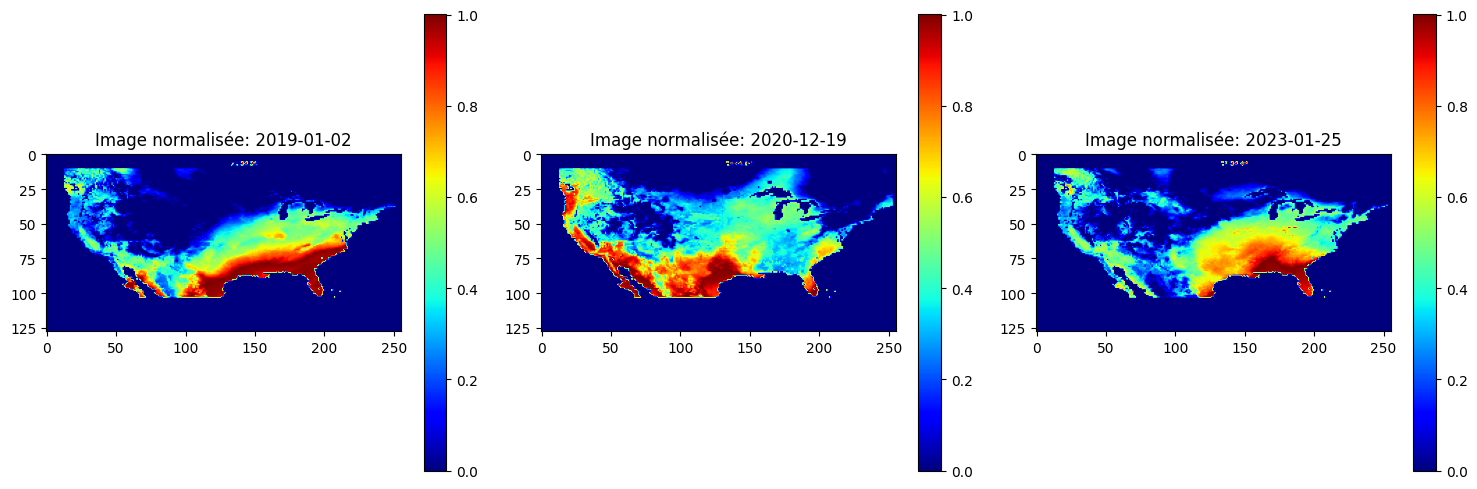

In [10]:
# Normalisation des données
print("Normalisation des données...")
scaler = MinMaxScaler(feature_range=(0, 1))

# Redimensionner pour appliquer le scaler
X_reshaped = X_images.reshape(X_images.shape[0], -1)
X_scaled = scaler.fit_transform(X_reshaped)
X_images_scaled = X_scaled.reshape(X_images.shape)

# Sauvegarde du scaler pour une utilisation ultérieure
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler sauvegardé à: {SCALER_SAVE_PATH}")

# Vérifier les valeurs min/max après normalisation
print(f"Valeur minimale après normalisation: {np.min(X_images_scaled)}")
print(f"Valeur maximale après normalisation: {np.max(X_images_scaled)}")

# Visualiser quelques exemples d'images normalisées
plt.figure(figsize=(15, 5))
for i in range(3):
    idx = i * (len(X_images) // 3)
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images_scaled[idx, :, :, 0], cmap='jet')
    plt.title(f"Image normalisée: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
def date_to_features(date_obj):
    """Convertit une date en caractéristiques temporelles utilisables par le modèle"""
    # Vérifier si l'entrée est déjà un objet datetime
    if isinstance(date_obj, str):
        date = datetime.strptime(date_obj, '%Y-%m-%d')
    else:
        # Si c'est déjà un objet datetime, l'utiliser directement
        date = date_obj
    
    # Extraire les caractéristiques temporelles
    year = date.year
    month = date.month
    day = date.day
    day_of_year = date.timetuple().tm_yday
    
    # Caractéristiques cycliques pour le mois et le jour de l'année
    month_sin = np.sin(2 * np.pi * month / 12)
    month_cos = np.cos(2 * np.pi * month / 12)
    day_sin = np.sin(2 * np.pi * day_of_year / 365)
    day_cos = np.cos(2 * np.pi * day_of_year / 365)
    
    return np.array([year, month, day, day_of_year, month_sin, month_cos, day_sin, day_cos])

def create_sequences_with_dates(data, dates, seq_length=30, pred_steps=7, batch_size=100):
    """
    Créer des séquences pour l'entraînement de séries temporelles avec caractéristiques de date
    Utilise le traitement par lots pour économiser la mémoire
    
    Args:
        data: Array numpy des images prétraitées
        dates: Liste des dates correspondantes
        seq_length: Longueur de la séquence d'entrée
        pred_steps: Nombre de pas de temps à prédire
        batch_size: Taille des lots pour économiser la mémoire
        
    Returns:
        X: Séquences d'entrée
        y: Séquences cibles (à prédire)
        date_features: Caractéristiques de date pour chaque séquence
    """
    total_sequences = len(data) - seq_length - pred_steps + 1
    print(f"Création de {total_sequences} séquences au total...")
    
    # Préallouer les tableaux pour économiser de la mémoire
    X = np.zeros((total_sequences, seq_length, *data.shape[1:]), dtype=np.float32)
    y = np.zeros((total_sequences, pred_steps, *data.shape[1:]), dtype=np.float32)
    date_features = np.zeros((total_sequences, 8), dtype=np.float32)  # 8 caractéristiques de date
    
    # Traitement par lots pour économiser la mémoire
    for start_idx in range(0, total_sequences, batch_size):
        end_idx = min(start_idx + batch_size, total_sequences)
        print(f"Traitement des séquences {start_idx} à {end_idx}...", end="\r")
        
        for i in range(start_idx, end_idx):
            # Séquence d'entrée: seq_length images consécutives
            X[i] = data[i:i+seq_length]
            # Séquence cible: pred_steps images suivantes
            y[i] = data[i+seq_length:i+seq_length+pred_steps]
            # Caractéristiques de date pour la dernière date de la séquence d'entrée
            last_date = dates[i+seq_length-1]
            date_features[i] = date_to_features(last_date)
        
        # Libérer la mémoire régulièrement
        if (end_idx - start_idx) % (batch_size * 5) == 0:
            gc.collect()
    
    print(f"\nNombre de séquences créées: {total_sequences}")
    
    
    return X, y, date_features



In [12]:
PREDICTION_STEPS=7
# Création des séquences avec caractéristiques de date
print("Création des séquences d'entraînement avec caractéristiques de date...")
X_seq, y_seq, date_features = create_sequences_with_dates(
    X_images_scaled, dates, SEQUENCE_LENGTH, PREDICTION_STEPS)

# Afficher les dimensions
print(f"Forme des séquences X: {X_seq.shape}")
print(f"Forme des séquences y: {y_seq.shape}")
print(f"Forme des caractéristiques de date: {date_features.shape}")

# Libérer de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()
optimize_memory()

# Division en ensembles d'entraînement et de validation (80/20)
split_idx = int(len(X_seq) * 0.8)
X_train, X_val = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_val = y_seq[:split_idx], y_seq[split_idx:]
date_features_train, date_features_val = date_features[:split_idx], date_features[split_idx:]

print(f"Ensemble d'entraînement: {X_train.shape[0]} séquences")
print(f"Ensemble de validation: {X_val.shape[0]} séquences")

# Libérer encore de la mémoire
try:
    del X_images, X_reshaped, X_scaled
except NameError:
    print("Certaines variables à supprimer n'existent pas, poursuite du processus...")
optimize_memory()

# Afficher quelques statistiques sur les caractéristiques de date
print("\nStatistiques des caractéristiques de date (ensemble d'entraînement):")
print(f"Années: min={date_features_train[:, 0].min()}, max={date_features_train[:, 0].max()}")
print(f"Mois: min={date_features_train[:, 1].min()}, max={date_features_train[:, 1].max()}")

Création des séquences d'entraînement avec caractéristiques de date...
Création de 694 séquences au total...
Traitement des séquences 600 à 694...
Nombre de séquences créées: 694
Forme des séquences X: (694, 30, 128, 256, 1)
Forme des séquences y: (694, 7, 128, 256, 1)
Forme des caractéristiques de date: (694, 8)
Ensemble d'entraînement: 555 séquences
Ensemble de validation: 139 séquences
Certaines variables à supprimer n'existent pas, poursuite du processus...

Statistiques des caractéristiques de date (ensemble d'entraînement):
Années: min=2019.0, max=2023.0
Mois: min=1.0, max=12.0


Chargement et prétraitement des images...
Nombre total de fichiers trouvés: 2191
Utilisation des 730 premiers fichiers
Dates triées: de 2019-01-02 00:00:00 à 2024-12-26 00:00:00
Traitement du lot 1/8 (0-100)...
Traitement du lot 2/8 (100-200)...
Traitement du lot 3/8 (200-300)...
Traitement du lot 4/8 (300-400)...
Traitement du lot 5/8 (400-500)...
Traitement du lot 6/8 (500-600)...
Traitement du lot 7/8 (600-700)...
Traitement du lot 8/8 (700-730)...
Forme finale des données: (730, 128, 256, 1)
Nombre d'images chargées: 730
Forme des images: (730, 128, 256, 1)
Première date: 2019-01-02 00:00:00
Dernière date: 2024-12-26 00:00:00


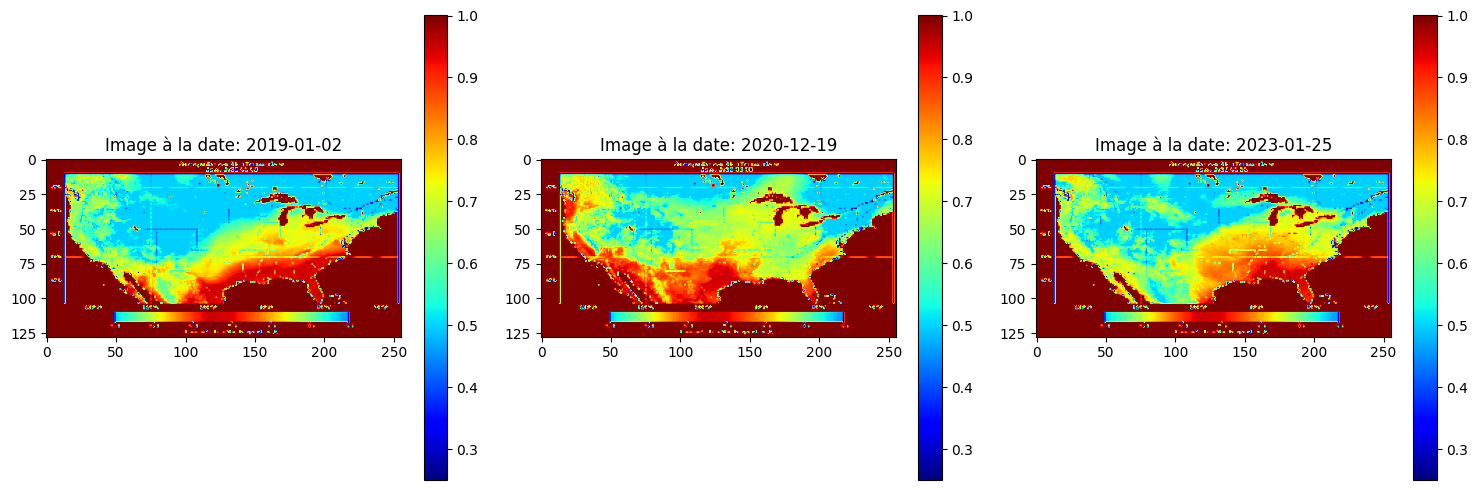

In [9]:
# Exécuter le chargement des données
print("Chargement et prétraitement des images...")
X_images, dates = load_and_preprocess_images(
    DATA_DIR, 
    img_height=IMG_HEIGHT, 
    img_width=IMG_WIDTH,
    max_images=730  # Environ 2 ans de données - ajustez selon vos besoins
)

# Afficher quelques informations
print(f"Nombre d'images chargées: {len(X_images)}")
print(f"Forme des images: {X_images.shape}")
print(f"Première date: {dates[0]}")
print(f"Dernière date: {dates[-1]}")

# Visualiser quelques exemples d'images
plt.figure(figsize=(15, 5))
for i in range(3):  # Afficher 3 images
    idx = i * (len(X_images) // 3)  # Prendre des images réparties uniformément
    plt.subplot(1, 3, i+1)
    plt.imshow(X_images[idx, :, :, 0], cmap='jet')
    plt.title(f"Image à la date: {dates[idx].strftime('%Y-%m-%d')}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Libérer de la mémoire
optimize_memory()

In [19]:
# Réduire la taille du batch pour économiser la mémoire
BATCH_SIZE = 4 * strategy.num_replicas_in_sync
SEQUENCE_LENGTH = 30  # Votre séquence a une longueur de 30

def build_lightweight_seq_model(seq_length, img_height, img_width, date_features_dim=8):
    """
    Construit un modèle léger qui accepte des séquences
    """
    # Entrée pour la séquence d'images
    seq_input = Input(shape=(seq_length, img_height, img_width, 1), name='seq_input')
    
    # Entrée pour les caractéristiques de date
    date_input = Input(shape=(date_features_dim,), name='date_input')
    
    # Pour chaque image de la séquence, nous allons extraire des caractéristiques
    # Nous utiliserons la dernière image de la séquence pour la prédiction
    last_frame = seq_input[:, -1]  # Prendre la dernière image de la séquence
    
    # Traitement de l'image avec un CNN léger
    # Niveau 1
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(last_frame)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # Niveau 2
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Niveau 3
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    
    # Extraction des caractéristiques globales de l'image
    global_img = tf.keras.layers.GlobalAveragePooling2D()(conv3)
    
    # Traitement des caractéristiques de date
    date_dense = Dense(32, activation='relu')(date_input)
    
    # Concaténer avec les caractéristiques de date
    concat_features = Concatenate()([global_img, date_dense])
    
    # Fusion des caractéristiques
    combined = Dense(64, activation='relu')(concat_features)
    combined = Dense(128, activation='relu')(combined)
    combined = Dense((img_height//4) * (img_width//4), activation='relu')(combined)
    combined = Reshape((img_height//4, img_width//4, 1))(combined)
    
    # Décodeur
    up1 = Conv2D(32, (3, 3), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(combined))
    up2 = Conv2D(16, (3, 3), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(up1))
    
    # Couche de sortie
    output = Conv2D(1, (1, 1), activation='sigmoid')(up2)
    
    model = Model(inputs=[seq_input, date_input], outputs=output)
    
    return model

In [20]:

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from datetime import datetime, timedelta
from tensorflow.keras.models import Model

# Création et compilation du modèle avec la stratégie multi-GPU
with strategy.scope():
    # Création du modèle
    print("Création du modèle léger compatibles avec les séquences...")
    model = build_lightweight_seq_model(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH)
    
    # Compilation du modèle
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            verbose=1, 
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=3, 
            verbose=1
        ),
        ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR, 'AvgSurfT_lightweight_model.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

# Afficher le résumé du modèle
model.summary()



Création du modèle léger compatibles avec les séquences...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)    │ (None, 30, 128, 256,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 128, 256, 1)    │              0 │ seq_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 256, 16)   │            160 │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 128, 16)    │              0 │ conv2d_12[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 128, 32)    │          4,640 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 64, 32)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ date_input (InputLayer)   │ (None, 8)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 64)             │              0 │ conv2d_14[0][0]        │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │            288 │ date_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 96)             │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          6,208 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │          8,320 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 2048)           │        264,192 │ dense_7[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 32, 64, 1)      │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_2           │ (None, 64, 128, 1)     │              0 │ reshape_1[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)   

 Total params: 307,265 (1.17 MB)

 Trainable params: 307,265 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

Début de l'entraînement...
Epoch 1/20


I0000 00:00:1745756912.944421      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745756912.960234      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0968 - mae: 0.2253
Epoch 1: val_loss improved from inf to 0.05655, saving model to /kaggle/working/avgsurft_checkpoints/AvgSurfT_lightweight_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0965 - mae: 0.2248 - val_loss: 0.0565 - val_mae: 0.1517 - learning_rate: 0.0010
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0625 - mae: 0.1605
Epoch 2: val_loss improved from 0.05655 to 0.04989, saving model to /kaggle/working/avgsurft_checkpoints/AvgSurfT_lightweight_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0624 - mae: 0.1605 - val_loss: 0.0499 - val_mae: 0.1374 - learning_rate: 0.0010
Epoch 3/20
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0528 - mae: 0.1418
Epoch 3: val_loss improved from 0.04989 to 0.04188, saving model to /kaggle/working/avgsurft_checkpoints/AvgSurfT_lightweight_model.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0527 - mae: 0.1416 - val_loss: 0.0419 - val_mae: 0

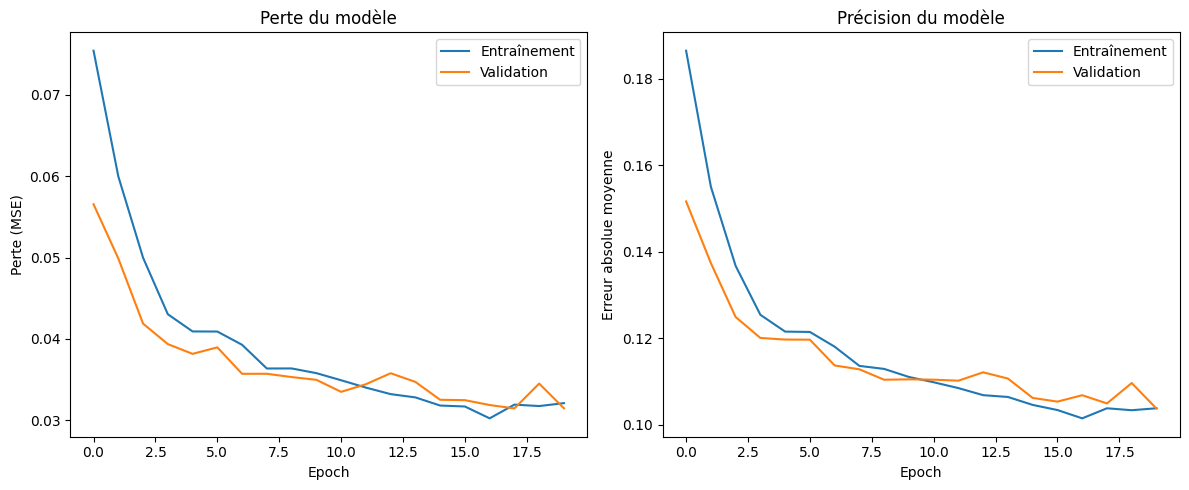

In [21]:
# Entraînement du modèle
print("Début de l'entraînement...")
history = model.fit(
    [X_train, date_features_train], y_train[:, 0],  # Prédire seulement la première image cible
    validation_data=([X_val, date_features_val], y_val[:, 0]),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Libérer de la mémoire
gc.collect()
tf.keras.backend.clear_session()

# Sauvegarder l'historique d'entraînement
hist_df = pd.DataFrame(history.history)
hist_csv_file = os.path.join(CHECKPOINT_DIR, 'history_avgsurft.csv')
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

print(f"Historique d'entraînement sauvegardé à: {hist_csv_file}")

# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte (MSE)')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Courbe de précision (MAE) 
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Précision du modèle')
plt.ylabel('Erreur absolue moyenne')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'learning_curves_avgsurft.png'))
plt.show()

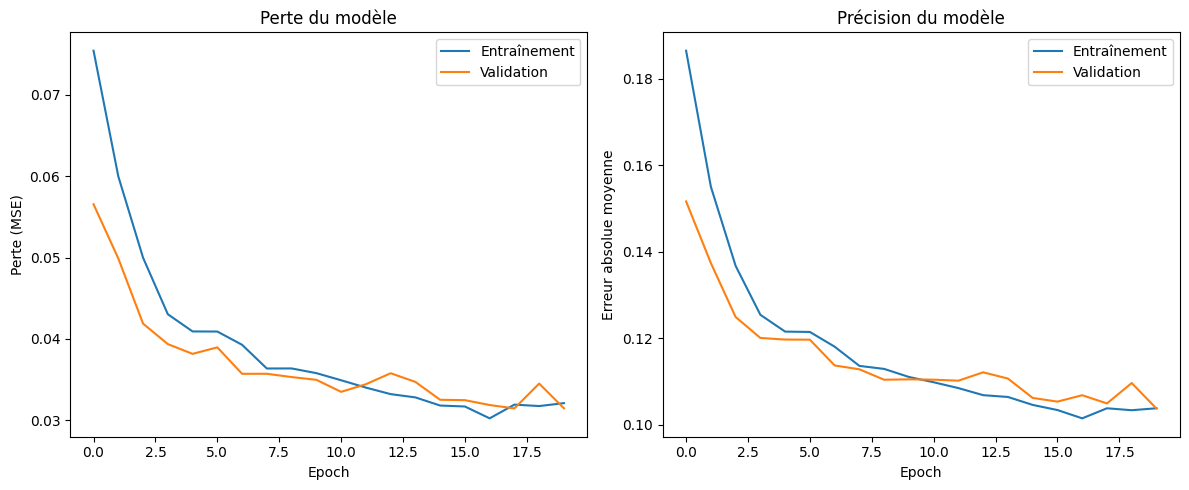

In [23]:
# Visualisation des courbes d'apprentissage
plt.figure(figsize=(12, 5))

# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perte du modèle')
plt.ylabel('Perte (MSE)')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')

# Courbe de précision (MAE)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Précision du modèle')
plt.ylabel('Erreur absolue moyenne')
plt.xlabel('Epoch')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
os.makedirs('models', exist_ok=True)  # Crée le dossier 'models' si besoin

plt.tight_layout()
plt.savefig('models/learning_curves_avgsurft.png')
plt.show()

In [40]:
def predict_map_for_date(model, target_date, scaler, img_height=128, img_width=256):
    """
    Prédit une carte pour une date spécifique
    """
    # Convertir la date en caractéristiques
    date = datetime.strptime(target_date, '%Y-%m-%d')
    day_of_year = date.timetuple().tm_yday
    month = date.month
    year = date.year
    
    # Créer les caractéristiques de date complètes (8 dimensions)
    day_of_week = date.weekday()
    week_of_year = date.isocalendar()[1]
    quarter = (month - 1) // 3 + 1
    is_weekend = 1 if day_of_week >= 5 else 0
    season = (month % 12 + 3) // 3
    
    # Créer le vecteur de caractéristiques complet avec 8 dimensions
    date_features = np.array([[day_of_year, month, year, day_of_week, week_of_year, quarter, is_weekend, season]])
    
    # Créer une image factice (dummy) avec la bonne forme
    dummy_img = np.zeros((1, 30, img_height, img_width, 1))
    
    # Faire la prédiction
    predicted_map_scaled = model.predict([dummy_img, date_features], verbose=0)
    
    # Correction: Traiter correctement la forme pour l'inverse_transform
    # Obtenir la forme originale avant de redimensionner
    original_shape = predicted_map_scaled.shape
    
    # Aplatir complètement le tableau pour l'inverse_transform
    flattened = predicted_map_scaled.flatten().reshape(-1, 1)
    
    # Appliquer l'inverse_transform
    predicted_map_values = scaler.inverse_transform(flattened)
    
    # Remettre en forme de carte
    return predicted_map_values.reshape(img_height, img_width)

In [56]:
print("Calcul de l'exactitude du modèle sur l'ensemble de validation...")

BATCH_SIZE = 32 # Exemple, ajustez si nécessaire

# 1. Faire des prédictions sur l'ensemble de validation
# --- CORRECTION ICI ---
# Passez une LISTE contenant les DEUX entrées attendues par le modèle
# Remplacez 'other_input_val' par le nom réel de votre deuxième variable d'entrée de validation
y_pred = model.predict([X_val, date_features_val], batch_size=BATCH_SIZE, verbose=1)
# --- FIN CORRECTION ---

# 2. Définir le seuil d'erreur acceptable (0.2 * écart-type des données cibles de validation)
threshold = 0.2 * np.std(y_val)

# ... reste du code pour calculer l'erreur, l'accuracy et afficher les graphiques ...

errors = np.abs(y_pred - y_val)
accuracy = np.mean(errors < threshold) * 100

print(f"Exactitude du modèle (seuil d'erreur = {threshold:.4f}):")
print(f"  {accuracy:.2f}% des prédictions sur l'ensemble de validation ont une erreur inférieure au seuil.")

# ... reste du code de visualisation ...

Calcul de l'exactitude du modèle sur l'ensemble de validation...
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step


ValueError: operands could not be broadcast together with shapes (139,128,256,1) (139,7,128,256,1) 